In [1]:
import torch
import torchvision
from torchvision import transforms
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.manifold import TSNE
import numpy as np

In [2]:

# Chargement du jeu de données MNIST
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),

    transforms.ToTensor(),
     transforms.Lambda(lambda x: x.repeat(3, 1, 1) ),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

])






100%|██████████| 9912422/9912422 [00:00<00:00, 119779520.84it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 101453679.92it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 30683700.90it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 14153438.91it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



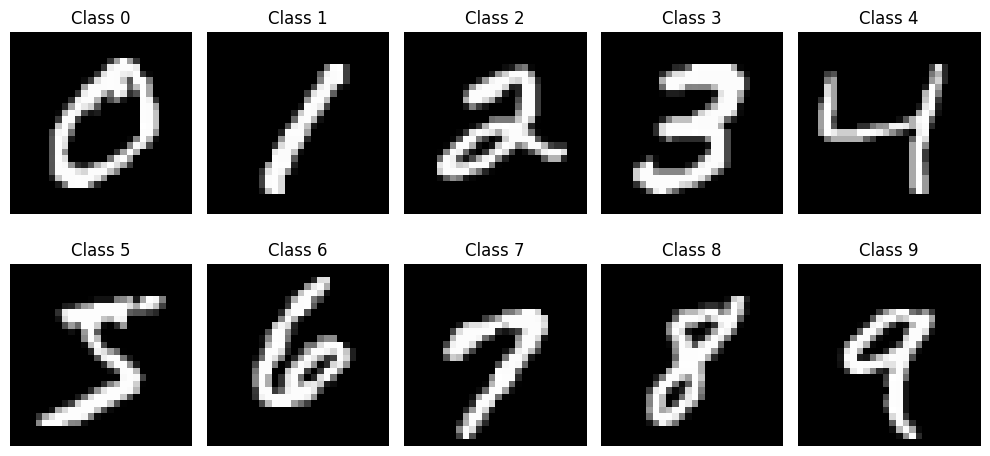

In [7]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform= torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    #torchvision.transforms.Normalize((0.5,), (0.5,))
]))
# Créer un dictionnaire pour stocker une image par classe
class_images = {}

# Boucle dans l'ensemble de données pour trouver une image par classe
for image, label in train_dataset:
    if label not in class_images:
        class_images[label] = image
        if len(class_images) == 10:  # Interrompre la boucle une fois qu'une image par classe a été trouvée
            break

# Tracer une image par classe
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(class_images[i].squeeze(), cmap='gray')
    plt.title(f"Class {i}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)


train_indices = []
for i in range(10):
    indices = (train_dataset.targets == i).nonzero().squeeze()[:1000]
    train_indices.extend(indices.tolist())

train_dataset = torch.utils.data.Subset(train_dataset, train_indices)


# Création des chargeurs de données
batch_size = 256
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
# Définition d'un modèle pré-entraîné (par exemple, VGG-16)
pretrained_model = torchvision.models.vgg16(pretrained=True).cuda()
pretrained_model.eval()
model = torch.nn.Sequential(*list(pretrained_model.features.children()))

# Extraction des caractéristiques du jeu de données
def extract_features(loader):
    all_features = []
    all_labels = []
    for images, labels in tqdm(loader):
        with torch.no_grad():
            features = model(images.cuda())
            all_features.append(features.view(features.size(0), -1).detach().cpu())  # Aplatir les caractéristiques
            all_labels.append(labels)
    return torch.cat(all_features).numpy(), torch.cat(all_labels).numpy()

train_features, train_labels = extract_features(train_loader)
test_features, test_labels = extract_features(test_loader)

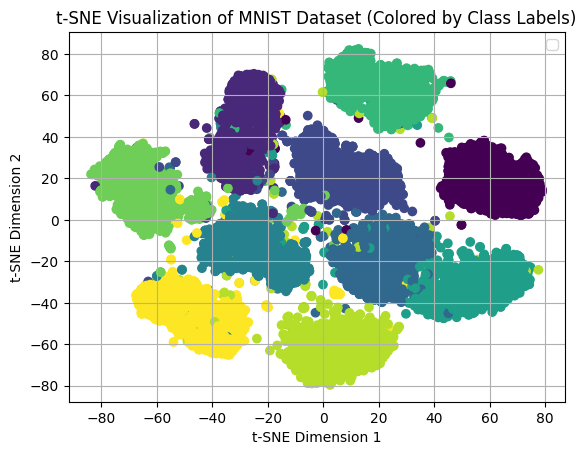

In [ ]:
X=np.vstack((train_features,test_features))
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X)

# Display t-SNE results colored by class labels

plt.scatter(X_embedded[:len(train_features), 0], X_embedded[:len(train_features), 1], c=train_labels )
plt.title('t-SNE Visualization of MNIST Dataset (Colored by Class Labels)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.grid(True)
plt.show()

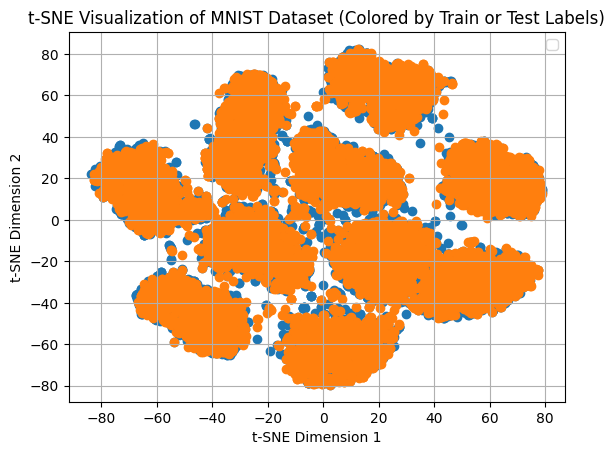

In [ ]:
plt.scatter(X_embedded[:len(train_features), 0], X_embedded[:len(train_features), 1])
plt.scatter(X_embedded[len(train_features):, 0], X_embedded[len(train_features):, 1])
plt.title('t-SNE Visualization of MNIST Dataset (Colored by Train or Test Labels)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Utilisation de k-means pour détecter les clusters de classes
num_classes = 10
kmeans = KMeans(n_clusters=num_classes, random_state=42)
kmeans.fit(X_embedded[:len(train_features)])

# Prédiction des clusters pour l'ensemble de validation
test_cluster_predictions = kmeans.predict(X_embedded[len(train_features):])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
train_cluster_predictions = kmeans.predict(X_embedded[:len(train_features)])

In [ ]:
test_cluster_predictions

array([1, 5, 4, ..., 8, 7, 2], dtype=int32)

In [ ]:
test_labels

array([7, 2, 1, ..., 4, 5, 6])

In [ ]:
# Calcul de la précision du modèle
accuracy = accuracy_score(test_labels, test_cluster_predictions)
print(f"Précision du modèle : {accuracy * 100:.2f}%")


Précision du modèle : 0.29%


In [ ]:
# Assignation des classes aux clusters en utilisant la majorité des étiquettes
def assign_class_to_cluster(cluster_labels, true_labels, num_clusters, num_classes):
    cluster_class_mapping = {}
    for cluster in range(num_clusters):
        cluster_labels_mask = cluster_labels == cluster
        class_counts = torch.bincount(true_labels[cluster_labels_mask], minlength=num_classes)
        predicted_class = torch.argmax(class_counts).item()
        cluster_class_mapping[cluster] = predicted_class
    return cluster_class_mapping

cluster_class_mapping = assign_class_to_cluster(train_cluster_predictions, torch.from_numpy(train_labels), num_classes, num_classes)

In [ ]:
# Classification de l'ensemble de validation en utilisant les clusters prédits
predicted_labels = [cluster_class_mapping[cluster] for cluster in test_cluster_predictions]

# Calcul de la précision du modèle
accuracy = accuracy_score(test_labels, predicted_labels)
print(f"Précision du modèle : {accuracy * 100:.2f}%")


Précision du modèle : 96.31%
